# Exercise 2 - Python:  Multi-class Classification and Neural Networks

## *Part One*: Multi-class Classification with Logistic Regression

Recognizing handwritten digits.  Though the source is not explicitly mentioned, it is just like the [MNIST database](https://en.wikipedia.org/wiki/MNIST_database).

Each value of $X$ will be a 20x20 grid of values representing the grayscale intensity at that location "unrolled" into a 400-dimensional vector.  Here is an example for the first number in our data, $X^{(1)}$:

$\hspace{1cm} X^{(1)} = \begin{bmatrix} x_{(1, 1)}^{(1)},\ x_{(1, 2)}^{(1)},\ \dots\ x_{(1, 20)}^{(1)} \\
                                    x_{(2, 1)}^{(1)},\ x_{(2, 2)}^{(1)},\ \dots\ x_{(2, 20)}^{(1)} \\
                                    \vdots \\ 
                                    x_{(20, 1)}^{(1)},\ x_{(20, 2)}^{(1)},\ \dots\ x_{(20, 20)}^{(1)} \\ 
                    \end{bmatrix}
\rightarrow \begin{bmatrix} x_1^{(1)},\ x_2^{(1)},\ \dots\ x_{400}^{(1)} \end{bmatrix}
\rightarrow (x^{(1)})^T$

Here is our collection of all of the numbers for $X$:

$\hspace{1cm} X = \begin{bmatrix} (x^{(1)})^T \\ (x^{(2)})^T \\ \vdots \\ (x^{(400)})^T \end{bmatrix}$

---

Beginning with package imports, data loading, and initial visualization

In [1]:
import numpy as np
import pandas as pd
from scipy import optimize  # Discovering optimal parameters
import matplotlib.pyplot as plt
import seaborn as sns

# For comparing answers
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

import scipy.io as sio # Used to load the Octave/MATLAB *.mat files

plt.style.use('ggplot')

%matplotlib inline

In [2]:
# Loading in the data from the .mat files
data = sio.loadmat('ex3/ex3data1.mat')
X, y = data['X'], data['y']

# Adding the intercept term for X
X = np.insert(X,  # Array to insert value into
              0,  # Index of where to insert
              1,  # Value
              axis=1)  # Along the columns

X.shape

(5000, 401)

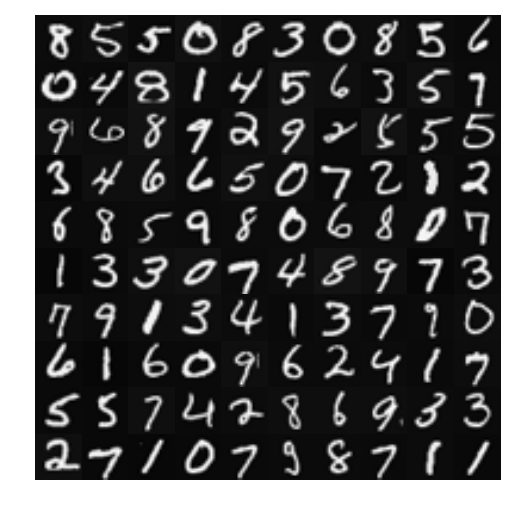

In [3]:
# Randomly sampling 100 numbers to display
random100 = X[np.random.randint(X.shape[0], size=100), 1:]  # 1: excludes the intercept

# Creating the overall figure to fill with plots of the numbers
fig = plt.figure(figsize=(6, 6))

# Loop over numbers to plot into the overall figure
for i, number in enumerate(random100):  # Enumerating to include index
    number = number.reshape(20, 20).T  # Reshape X into 20x20 array
    ax = fig.add_subplot(10, 10, i+1)  # Rows, Columns, positioning
    plt.imshow(number, cmap='gray')  # Plotting the number
    
    # Removing unnecessary components for aesthetics
    plt.grid(False)
    plt.axis('off')
    fig.subplots_adjust(wspace=0, hspace=0)
    
plt.show()

### Vectorizing Logistic Regression

We'll be taking a matrix multiplication approach to vectorize both the cost function and the gradient for logistic regression.  My previous notebooks for assignment \#2 ([Python](http://nbviewer.jupyter.org/github/JeffMacaluso/Misc/blob/master/MachineLearningMOOC/Ex2%20Python%20-%20Logistic%20Regression.ipynb) | [R](http://nbviewer.jupyter.org/github/JeffMacaluso/Misc/blob/master/MachineLearningMOOC/Ex2%20R%20-%20Logistic%20Regression.ipynb) | [Julia](http://nbviewer.jupyter.org/github/JeffMacaluso/Misc/blob/master/MachineLearningMOOC/Ex2%20Julia%20-%20Logistic%20Regression.ipynb)) already use a vectorized approach, but I'll have a little more information describing what is happening below.

- **Note:** The assignment calls for creating the functions for unregularized logistic regression and later modifying them for regularization, but I'm just going to write the functions for regularized logistic regression right away since the regularization parameter is generally just an addition at the end of the equations.

To illustrate this vectorization process, here is how we vectorize our hypothesis, $h_\theta(x)$, using matrix multiplication with the axiom that $a^Tb = b^Ta$ if $a$ and $b$ are vectors:

Defining $X$ and $\theta$ as

$\hspace{1cm} X = \begin{bmatrix} (x^{(1)})^T \\ (x^{(2)})^T \\ \vdots \\ (x^{(m)})^T \end{bmatrix} \hspace{0.5cm}$ and $\hspace{0.5cm} \theta = \begin{bmatrix} \theta_0 \\ \theta_1 \\ \vdots \\ \theta_n \end{bmatrix}$

Computing matrix product $X\theta$:

$\hspace{1cm} X\theta = \begin{bmatrix} (x^{(1)})^T\theta \\ (x^{(2)})^T\theta \\ \vdots \\ (x^{(m)})^T\theta \end{bmatrix} \hspace{0.5cm} = \hspace{0.5cm} \begin{bmatrix} \theta^T(x^{(1)}) \\ \theta^T(x^{(2)}) \\ \vdots \\ \theta^T(x^{(m)}) \end{bmatrix}$

#### Vectorized Cost Function

#### Vectorized Gradient

#### One-vs-all Classification

---

##  **Part 2:** Neural Networks

Predicting acceptance of microchips based off of two tests